In [1]:
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

sc = spark.SparkContext()
sql = spark.SQLContext(sc)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [2]:
# Read and prepare data to LSTM time series model

df = pd.read_csv('btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df.sort_values('DateTime')
df.set_index('DateTime',inplace=True)
df.head()

,Negative,Neutral,Positive,Compound,Price
DateTime,,,,,
2020-07-01,0.0,0.741,0.259,0.8126,144.8
2020-07-02,0.0,0.000,0.000,0.0000,18.0
2020-07-03,0.0,0.000,0.000,0.0000,-67.3
2020-07-04,0.0,0.000,0.000,0.0000,53.4
2020-07-05,0.0,0.000,0.000,0.0000,-258.0


In [3]:
# Scale the dataframe for better results

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

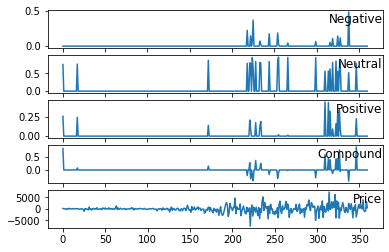

In [4]:
# Plot the time series of all features

values = df.values
groups = [0,1,2,3,4]
i = 1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [5]:
# Reframe the data so we can apply supervised learning techniques in a time series
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

n_days = 1
n_features = 5
n_obs = n_days * n_features

reframed = series_to_supervised(scaled, n_days, 1)

reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.0,0.77918,0.583333,0.956370,0.517534,0.0
2,0.0,0.00000,0.000000,0.326643,0.508997,0.0
3,0.0,0.00000,0.000000,0.326643,0.503255,0.0
4,0.0,0.00000,0.000000,0.326643,0.511381,0.0
5,0.0,0.00000,0.000000,0.326643,0.490417,0.0


In [6]:
# Split train and test data

train_size = 0.7
n_train_days = int(len(reframed)*train_size)

df_shuffled = shuffle(reframed)

values = df_shuffled.values
train = values[:n_train_days, :]
test = values[n_train_days:, :]

train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

Epoch 1/20
63/63 - 2s - loss: 0.0678 - val_loss: 0.0463
Epoch 2/20
63/63 - 0s - loss: 0.0646 - val_loss: 0.0442
Epoch 3/20
63/63 - 0s - loss: 0.0624 - val_loss: 0.0425
Epoch 4/20
63/63 - 0s - loss: 0.0600 - val_loss: 0.0403
Epoch 5/20
63/63 - 0s - loss: 0.0568 - val_loss: 0.0380
Epoch 6/20
63/63 - 0s - loss: 0.0537 - val_loss: 0.0354
Epoch 7/20
63/63 - 0s - loss: 0.0499 - val_loss: 0.0323
Epoch 8/20
63/63 - 0s - loss: 0.0456 - val_loss: 0.0289
Epoch 9/20
63/63 - 0s - loss: 0.0406 - val_loss: 0.0250
Epoch 10/20
63/63 - 0s - loss: 0.0348 - val_loss: 0.0212
Epoch 11/20
63/63 - 0s - loss: 0.0292 - val_loss: 0.0172
Epoch 12/20
63/63 - 0s - loss: 0.0239 - val_loss: 0.0155
Epoch 13/20
63/63 - 0s - loss: 0.0199 - val_loss: 0.0145
Epoch 14/20
63/63 - 0s - loss: 0.0167 - val_loss: 0.0133
Epoch 15/20
63/63 - 0s - loss: 0.0145 - val_loss: 0.0129
Epoch 16/20
63/63 - 0s - loss: 0.0130 - val_loss: 0.0120
Epoch 17/20
63/63 - 0s - loss: 0.0114 - val_loss: 0.0116
Epoch 18/20
63/63 - 0s - loss: 0.0105 - 

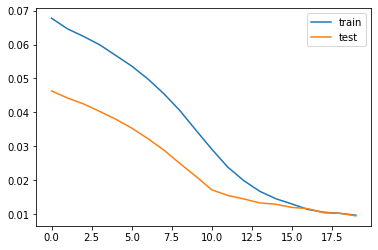

In [7]:
# Create the LSTM model, train it and plot the value loss

model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

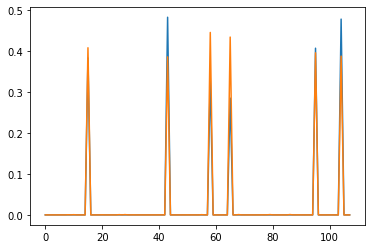

In [8]:
# Make predictions and plot

predictions = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days * n_features))

inv_predictions = np.concatenate((predictions, test_X[:, -4:]), axis=1)
inv_predictions = scaler.inverse_transform(inv_predictions)
inv_predictions = inv_predictions[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.plot(inv_y)
plt.plot(inv_predictions)
plt.show()

In [9]:
# Print the results

mse = mean_squared_error(inv_y, inv_predictions)
r2 = r2_score(inv_y, inv_predictions)
rmse = np.sqrt(mse)

print("Coefficient of Determination  (R2):", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Square Error: %.3f" % rmse)

Coefficient of Determination  (R2): 0.9420237536614633
Mean Squared Error (MSE): 0.0004917124029328136
Root Mean Square Error: 0.022


In [11]:
# Save the predictions data to csv file

df_sol = pd.DataFrame({'forecast':inv_predictions,'actual':inv_y})
df_sol.to_csv('predictions_lstm.csv')